# Example for rigid alignment with object oriented lib

## Git clone and package installation

First, you will need to git clone this repo as follows:
1. `git clone https://github.com/donglaiw/ExM-Toolbox/tree/jack` (i.e. not branch main!)
Then, checkout branch jack
2. `cd ExM-Toolbox`
3. `git checkout jack`
Now, install package as described in the `README.md`, make sure you are installing things properly, often times my python path is messed up, getting the path to your conda env via 
`conda info --envs` and running `/path/to/your/conda/env/bin/pip install -r requirements.txt --editable .` (make sure you are in ExM-Toolbox when you run this!)



# Library walkthrough

This library is inspired by Zudi Lin's [pytorch connectomics](https://github.com/zudi-lin/pytorch_connectomics/tree/5b2cf5848fc4f458666cda1ee9d69c80601fc3c8) object oriented library. At it's core it generally follows a similar structure which is defined as below:

## config

In elementary school the earliest exposure I have ever had to reproducibility was the [peanut butter and jelly experiment](https://www.youtube.com/watch?v=Ct-lOOUqmyY). A similar thing can be said of scientific computing, the Dad is another scientist that would like to use our technology on our own sample. If our instructions are not rigid, explicit, and robust, then the experiment will not be reproducible and who's to claim what we discovered is real. In computing this ususally comes down to parameters, to avoid overwriting parameters, or writing parameters to a global variable that we forget about, we can simply use a configuration file like below. 

In [6]:
from exm.config.utils import load_cfg
import json

cfg = load_cfg()

pretty_cfg = json.dumps(cfg, indent = 4)

print(pretty_cfg)

{
    "SYSTEM": {},
    "ALIGN": {
        "RESOLUTION": [
            1.625,
            1.625,
            4.0
        ],
        "TRANSFORM_TYPE": [
            "rigid"
        ],
        "NUM_ITERATION": -1,
        "NumberOfSamplesForExactGradient": "100000",
        "MaximumNumberOfIterations": "10000",
        "MaximumNumberOfSamplingAttempts": "100",
        "FinalBSplineInterpolationOrder": "1"
    },
    "DATASET": {
        "VOL_FIX_PATH": "path/to/vol_fix",
        "VOL_MOVE_PATH": "path/to/vol_move",
        "OUTPUT_PATH": "path/to/out_path",
        "ITER_AXES": "v",
        "FOV": null,
        "CHANNEL": null,
        "MASK_FIX_PATH": null,
        "MASK_MOV_PATH": null
    }
}


What this now gives us is a reproducbile set of parameters that anyone can copy and use to get the same results we did. Furthermore as our technologies become developed people can edit these configurations, then distribute them to the general public in a coherent and accessible manner. We will use this cfg dictionary and it's contents throughout the tutorial.

## data

This module enforces a consistent structrue and format to be used for `.h5` and `.nd2` files, such that, in simplest case, to load a file all you need to provide is a path. Additionally, you may specify what field of view or name of `.h5` dataset you would like to work with as well. By using the object oriented format we can have greater source control and optmizie data loading and manipulation. 

The currently the core module for our data lib is the `datasetVolume` object and is discussed below

In [15]:
# import class
from exm.data.dataset_volume import datasetVolume

# specify vol path in cfg, must defrost otherwise you will get an unmutable error
cfg.defrost()
cfg.DATASET.VOL_FIX_PATH = '/mp/nas2/ruihan/20220512/20220512_Code3/Channel405 SD_Seq0004.nd2'
cfg.DATASET.VOL_MOVE_PATH = '/mp/nas2/ruihan/20220512/20220512_Code5/Channel405 SD_Seq0004.nd2'
cfg.DATASET.FOV = 23
# freeze again so we dont accidentally overwrite anything
cfg.freeze()

# init obj and load nd2
dset = datasetVolume()
dset.loadVol(vol_path = cfg.DATASET.VOL_FIX_PATH,
                        iter_axes = 'v')

dset

Note that this is a custom data object, from our `data` module. It has several attributes:
 - `dset.vol` this is the `ND2Reader` object  of the path you specify, it should be the length of your number of fields of view, and you may index it as so (i.e. dset.vol[0] is fov 0)
 - `dset.iter_axis` is the axis of iteration, you could change this to `t` if you had multiple time points as well
 - `dset.bundle_axis` is the attribute you should set to bundle the correct spatial axes together, we choose `zyx` as that is the format `numpy` represents arrays. 
 - `dset.mask` is the mask you would like to use for computing the trasformaiton, you must use `dset.setMasks` to set it. 

We will see later on that using another function, called `get_dataset` will allow us to abstract away a lot of the boilder plate code that might come with just using this object by itself to read data into our transformaiton function. 

## align

This is the module that hosts all the code that we use to interface with SimpleITK, the python library that allows us to do rigid registration. For this example lets just consider the `sitkTile` object. 

In [19]:
from exm.align.sitk_tile import sitkTile

# init obj, must pass cfg
sitkT = sitkTile(cfg)

dir(sitkT)[-18:]

['cfg',
 'computeMask',
 'computeTransformMap',
 'convertSitkImage',
 'createParameterMap',
 'elastix',
 'getParameterMap',
 'num_iteration',
 'parameter_map',
 'readTransformMap',
 'resolution',
 'setResolution',
 'setTransformType',
 'transform_type',
 'transformix',
 'updateParameterMap',
 'warpVolume',
 'writeTransformMap']

As you can see `sitkTile` has quite a few methods and attributes. The main atrribs we will use are `elastix` which computes the transformation and `transformix` which transforms the image. The methods we will use are `computeTransformMap` and `warpVolume`. 

To use sitkTile we need to first specify quite a few things like the [parameter map](https://simpleelastix.readthedocs.io/ParameterMaps.html), image resolution, etc. If we were to call all these sequentially it would result in a lot of boiler plate code, and we would lose a decent amount of modularity at the library's core. So instead we can create another class that inherits the sitkTile object and builds it for us abstracting that code away. 

In [20]:
from exm.align.build import alignBuild

align = alignBuild(cfg)

align.buildSitkTile()

Here is a quick lesson on [class inheritance](https://docs.python.org/3/tutorial/classes.html) in object oriented programming. First take a look at the last 18 attributes and methods of our `sitkTile` object printed above, and now look at the last 18 of our new `alignBuild` object below.

In [24]:
print(dir(align)[-18:] == dir(sitkT)[-18:])
dir(align)[-18:]

True


['cfg',
 'computeMask',
 'computeTransformMap',
 'convertSitkImage',
 'createParameterMap',
 'elastix',
 'getParameterMap',
 'num_iteration',
 'parameter_map',
 'readTransformMap',
 'resolution',
 'setResolution',
 'setTransformType',
 'transform_type',
 'transformix',
 'updateParameterMap',
 'warpVolume',
 'writeTransformMap']

They're the same! This is because we made `alignBuild` a child of `sitkTile`, but if we look at the other objects of `alignBuild` we can see that it has some unique features. The main one being `alignBuild.buildSitkTile`, which creates a parameter map based on the parameters specified in `cfg.ALGIN` and sets the parameter map to the `elastix` object in `sitkTile`. 

In [27]:
print(dir(align) == dir(sitkT))
dir(align)[-19:-15]

False


['buildSitkTile', 'cfg', 'computeMask', 'computeTransformMap']

This design of `object` -> `build` -> `run` allows for significant modularity, and we actually do the same with the dataset object discussed earlier, and now we will see how it all comes together in the runner object.

## engine

Now that we have our peanut butter (i.e. the objs from the `data` module), jelly (i.e. the objs from the `align` module), we can put them together in a sandwich (i.e. build as shown above) and eat it (i.e. run the dang thing)! 

In [ ]:
# let's build things the hard way, then the easy way
from exm.align.build import alignBuild
from exm.data.build import getDataset

# get dataset allows us to abstract away the first code we saw, and will return dataset objs for both the fixed and moving volumes while simply just passing in cfg
fix_vol, mov_vol = getDataset(cfg)

# build align, note sitk object is hidden within this
align = alignBuild(cfg)
align.buildSitkTile()

# remember these guys are inherited from sitkTile! and vol.mask is None unless you set it, commented out bc they take a long time
#tform = align.computeTransformMap(fix_vol.vol, mov_vol.vol, mask_fix = fix_vol.mask, mask_move = mov_vol.mask)
#result = align.warpVolume(mov_vol.vol, tform)

That is not very modular if we were to put that into a final script. What if we made things such that we want to call a class `Runner` so that each time we run alignment we are not restricted to `sitkTile`, this would be especially useful for when we build out the library more with objects like `sitkPoint`, etc.

Installing all components.
InstallingComponents was successful.

ELASTIX version: 5.000
Command line options from ElastixBase:
-fMask    unspecified, so no fixed mask used
-mMask    unspecified, so no moving mask used
-out      ./
-threads  unspecified, so all available threads are used
  The default value "true" is used instead.

  From elastix 4.8 it defaults to true!
This may change the behavior of your registrations considerably.

Command line options from TransformBase:
-t0       unspecified, so no initial transform used

Reading images...
Reading images took 0 ms.

  A default pyramid schedule is used.
  A default pyramid schedule is used.
  The default value "false" is used instead.
  The default value "GeometricalCenter" is used instead.
Transform parameters are initialized as: [0, 0, 0, 0, 0, 0]
Scales are estimated automatically.
Scales for transform parameters are: [1007255.56640625, 1007255.56640625, 1884911.1328125, 1, 1, 1]
Initialization of all components (before registr

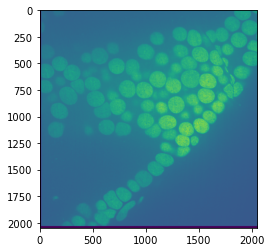

In [28]:
from exm.engine.runner import Runner
import matplotlib.pyplot as plt
%matplotlib inline

run = Runner()
tform, result = run.runAlign(cfg)

print(tform.items())
plt.imshow(result[200,:,:])

So all in all the simply need these lines of code to run rigid alignment:

In [ ]:
from exm.config.utils import load_cfg
from exm.engine.runner import Runner

#get config file
cfg = load_cfg()

#defrost to add vol paths and fov
cfg.defrost()

cfg.DATASET.VOL_FIX_PATH = '/mp/nas2/ruihan/20220512/20220512_Code3/Channel405 SD_Seq0004.nd2'
cfg.DATASET.VOL_MOVE_PATH = '/mp/nas2/ruihan/20220512/20220512_Code5/Channel405 SD_Seq0004.nd2'
cfg.DATASET.FOV = 23

cfg.freeze()
# init runner obj and run align

run = Runner()
tform, result = run.runAlign(cfg)

print(tform.items())
plt.imshow(result[200,:,:])

Ain't that nice? 

In the runner class there is a minor error on [line 20](https://github.com/donglaiw/ExM-Toolbox/blob/7e6d16dbd27c409035439a0586ec4152f9849af9/exm/engine/runner.py#L20). A good practice to learn git would be to remove the `self.cfg` variable so that it is just `self.align.buildSitkTile()`, and [perform a pull request](https://docs.github.com/en/pull-requests/collaborating-with-pull-requests/proposing-changes-to-your-work-with-pull-requests/creating-a-pull-request)